In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
# import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image

import random
from PIL import Image
import cv2

ModuleNotFoundError: No module named 'numpy'

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
%cd /home/spyros/Desktop/DNN/
data = pd.read_csv('data_enum.csv')
data

/home/spyros/Desktop/DNN


,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path
0,HAM_0001751,ISIC_0024698,1,consensus,70,male,face,False,HAM10000_images_part_1/nv/ISIC_0024698.jpg
1,HAM_0000559,ISIC_0024693,1,follow_up,45,female,upper extremity,False,HAM10000_images_part_1/nv/ISIC_0024693.jpg
2,HAM_0004932,ISIC_0032212,1,follow_up,45,female,foot,False,HAM10000_images_part_2/nv/ISIC_0032212.jpg
3,HAM_0004516,ISIC_0025775,1,follow_up,45,female,neck,False,HAM10000_images_part_1/nv/ISIC_0025775.jpg
4,HAM_0006510,ISIC_0029828,1,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0029828.jpg
...,...,...,...,...,...,...,...,...,...
30900,HAM_0000982,ISIC_0032356,6,histo,60,male,lower extremity,False,HAM10000_images_part_2/akiec/ISIC_0032356.jpg
30901,HAM_0006746,ISIC_0026872,6,histo,85,male,lower extremity,False,HAM10000_images_part_1/akiec/ISIC_0026872.jpg
30902,HAM_0004033,ISIC_0027452,6,histo,70,male,upper extremity,False,HAM10000_images_part_1/akiec/ISIC_0027452.jpg
30903,HAM_0002472,ISIC_0025696,6,histo,60,male,face,False,HAM10000_images_part_1/akiec/ISIC_0025696.jpg


In [ ]:
# colored_array = data.iloc[0]['image_path']
# img = Image.open(colored_array)
# img.size


# Convert the Data to Tensors

In [ ]:
# def compute_img_mean_std(image_paths):
#     img_h, img_w = 224, 224
#     n_pixels = 0
#     sum_channels = np.zeros(3)
#     sum_squares_channels = np.zeros(3)

#     for path in tqdm(image_paths):
#         img = cv2.imread(path)
#         img = cv2.resize(img, (img_w, img_h))
#         img = img.astype(np.float32) / 255.

#         sum_channels += img.sum(axis=(0, 1))
#         sum_squares_channels += (img ** 2).sum(axis=(0, 1))
#         n_pixels += img_h * img_w

#     mean_channels = sum_channels / n_pixels
#     std_channels = np.sqrt(sum_squares_channels / n_pixels - mean_channels ** 2)

#     # Convert from BGR to RGB
#     mean_channels = mean_channels[::-1].tolist() #error rises when they are arrays
#     std_channels = std_channels[::-1].tolist()
#     print(f"normMean = {mean_channels}")
#     print(f"normStd = {std_channels}")

#     return mean_channels, std_channels

In [ ]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'])

**Data rotation, cutting and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [ ]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((224,224)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor()])#, transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])#,
                                    # transforms.Normalize(norm_means, norm_std)])

In [ ]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx',img_col='image_path', transform=None):
        self.data = data
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform # or transforms.ToTensor()  # Normalize the pixels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx][self.img_col]
        image = Image.open(image_path)

        label = torch.tensor(self.data.iloc[idx][self.label_column])

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
data = data.sample(frac=1) 

train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=train_transform)
val_dataset = HAM10000Dataset(val_data, transform=val_transform)
test_dataset = HAM10000Dataset(test_data, transform=val_transform)

In [ ]:
batch_size = 108
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Data Len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data Len Train: 18543 Val: 6181 Test: 6181


/tmp/ipykernel_17488/3085834344.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(random_img.T)


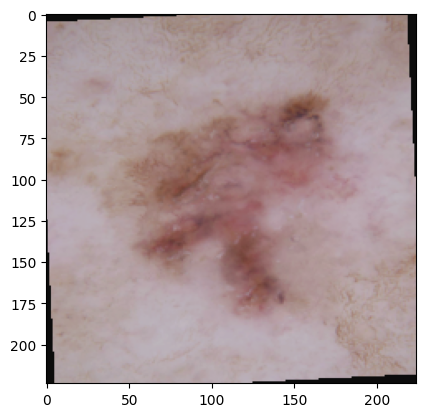

In [ ]:
rand = random.randint(0, train_data.shape[0])

sample_image_path = train_data.iloc[rand]['image_path']
sample_image = Image.open(sample_image_path)

random_img = train_transform(sample_image)

plt.imshow(random_img.T)

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array(norm_means)
#     std = np.array(norm_std)
#     inp = std * inp + mean  # Unnormalize
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)


# imshow(random_img, title='Random Image')

# Make the custom model

In [ ]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
        
        # Pooling layer - using Maxpooling with Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # Size calculation depends on the input image size and conv/pool layers
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)  # num_classes is the number of your output classes

    def forward(self, x):
        # Apply convolutions and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Apply fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
cnnet = CNNet()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnnet = cnnet.to(device)

In [ ]:
input_size = (3, 224, 224)
summary(cnnet, input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Linear-9                  [-1, 512]      12,845,568
           Linear-10                  [-1, 256]         131,328
           Linear-11                    [-1, 7]           1,799
Total params: 13,076,135
Trainable params: 13,076,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

In [ ]:
optimizer = optim.Adam(cnnet.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
num_epochs = 20  

for epoch in range(num_epochs):
    cnnet.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:  # Iterate over the training dataset
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = cnnet(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/20], Loss: 1.555176189472509
Epoch [2/20], Loss: 1.1234480807947558
Epoch [3/20], Loss: 0.9294507642124974
Epoch [4/20], Loss: 0.758035768256631
Epoch [5/20], Loss: 0.6867518958657287
Epoch [6/20], Loss: 0.5655562267747036
Epoch [7/20], Loss: 0.5162710316999014
Epoch [8/20], Loss: 0.43649773628905764
Epoch [9/20], Loss: 0.3937914956274421
Epoch [10/20], Loss: 0.3216944839372191
Epoch [11/20], Loss: 0.29696559308226717
Epoch [12/20], Loss: 0.250714153138011
Epoch [13/20], Loss: 0.22617248480403146
Epoch [14/20], Loss: 0.218881462895593
Epoch [15/20], Loss: 0.19001384057797666
Epoch [16/20], Loss: 0.1735244885433552
Epoch [17/20], Loss: 0.15800059868326022
Epoch [18/20], Loss: 0.1625239070028413
Epoch [19/20], Loss: 0.135935724019831
Epoch [20/20], Loss: 0.125752019479351


In [ ]:
cnnet.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total}%')


Validation Accuracy: 98.04238796311276%


In [ ]:
cnnet.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')



Accuracy: 97.88060184436175%


In [ ]:
torch.save(cnnet.state_dict(), 'cnnet_model.pth')  # Save the model's state dictionary

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-01-11 12:09:30.376773: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 12:09:30.404367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 12:09:30.404393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 12:09:30.405117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 12:09:30.409686: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-01-11 12:09:31.359007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:09:31.365370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:09:31.365533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import tensorflow as tf

# List all available devices
devices = tf.config.list_physical_devices()
print("Available devices:", devices)

# Specifically list GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

# Disable eager execution to use TensorFlow 1.x style sessions
tf.compat.v1.disable_eager_execution()

# Config to log device placement and create session
config = ConfigProto()
config.log_device_placement = True
sess = InteractiveSession(config=config)

# Your TensorFlow 1.x code here
# ...

sess.close()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



2024-01-11 12:16:41.081604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:16:41.081888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:16:41.082043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs were detected.")


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-01-11 12:34:24.065791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 12:34:24.092486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 12:34:24.092517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 12:34:24.093218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 12:34:24.097850: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-01-11 12:34:25.145330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:34:25.167695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:34:25.167847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
tf_data = tf.random.uniform([1000, 1000])
result = tf.matmul(tf_data, tf_data)
print(result)


tf.Tensor(
[[249.29689 243.88899 253.44232 ... 236.32626 251.02528 248.44347]
 [245.75801 239.85109 249.95052 ... 240.14581 257.20535 255.39983]
 [252.19763 245.99884 247.28177 ... 241.49823 253.03041 249.09619]
 ...
 [241.16876 238.46918 246.6854  ... 229.91356 246.18777 235.82684]
 [261.21106 258.37097 270.80997 ... 248.67986 265.94308 260.86673]
 [246.84174 238.80098 244.67215 ... 233.67319 247.77545 245.35216]], shape=(1000, 1000), dtype=float32)
